# Solve the filtre problem with DAEs solvers

## Mathematical modelling

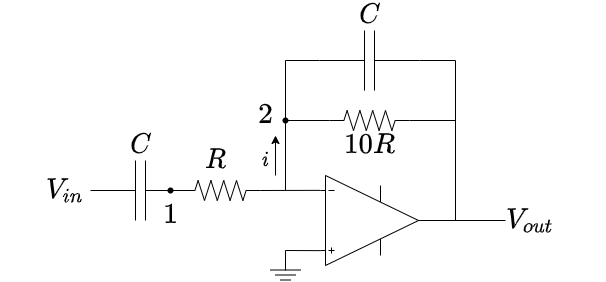

In [1]:
from IPython.display import Image
Image(filename="img/circuit_filtre.png")

Kirchhoff law of currents on nodes 1 and 2:
1. $i = C \frac{d(V_{in} - V_1)}{dt} = \frac{V_1}{R}$
2. $i = \frac{-V_{out}}{10R} + C \frac{d(-V_{out})}{dt}$

wich gives the following DAE system : 
\begin{align*}
\left\{
\begin{aligned}
        \dot{V_1} &= \dot{V_{in}} - \frac{i}{C} \\
        \dot{V_{out}} &= -\frac{V_{out}}{10RC} - \frac{i}{C} \\
        0 &= i \; R - V_1 
\end{aligned}
\right.
\end{align*}
with $V_{in} = sin(\frac{10}{RC} t)$ so we have $\dot{V_{in}} = \frac{10}{RC} cos(\frac{10}{RC} t)$

The ODE system can be determine by inject the algebraic contraint in the two first equations :
\begin{align*}
\left\{
\begin{aligned}
        \dot{V_1} &= \dot{V_{in}} - \frac{V_1}{RC} \\
        \dot{V_{out}} &= -\frac{V_{out}}{10RC} - \frac{V_1}{RC} \\
\end{aligned}
\right.
\end{align*}

## Solving those systems with DAEs solvers

In [2]:
# import solvers
from solvers.bdf import BDFModified
from solvers.radau import RadauModified
from solvers.rosenbrock import Rosenbrock
from solvers.sabm import SABM

In [3]:
# import other useful modules
from time import time
from matplotlib import pyplot as plt
from scipy.integrate import solve_ivp
from scipy.optimize import fsolve
import numpy as np

Declare the constants of the transistor amplifier problem:

In [4]:
R = 1000 
C = 1*1e-4

def V_in(t): return np.sin(10/(R*C) * t)
def dVdt(t): return 10/(R*C) * np.cos(10/(R*C) * t)

tspan = [0, 1]
vout = 0.1
i0 = -vout/R
v1 = i0*R

vout = 0
v1 = 0
i0 = 0

y0 = np.array([v1, vout, i0]) # initial condition for the DAE system

Create the function describing the DAEs systems such that $M\dot{y}=f(t,y)$ : 

In [5]:
def f_transistor_index1(t, y):
    V1, Vout, i = y[0], y[1], y[2]
    return np.array([dVdt(t) - i/C,
                    -Vout/(10*R*C) - i/C, 
                    R*i - V1])

# mass matrix
M = np.eye(3)
M[-1,-1] = 0

# functions of the rhs linked to the derivatives, it's the rhs of the ODE part of the DAE system
def fun(t, y, x):
    V1, V_out = y
    i = x[0]
    return np.array([dVdt(t) - i/C,
                     -V_out/(10*R*C) - i/C])

# algebraic constraints
def gun(t, y, x):
    V1, V_out = y
    i = x[0]
    return np.array([V1/R - i])

Parameters of the DAEs solvers similar to those scipy solve_ivp:

In [6]:
kwargsBDF = {
    'fun': f_transistor_index1,
    't_span': tspan,
    'y0': y0,
    'mass': M,
    'method': BDFModified,
    'rtol': 1e-5,
    'atol': 1e-5
}

kwargsRadau = {
    'fun': f_transistor_index1,
    't_span': tspan,
    'y0': y0,
    'mass': M,
    'method': RadauModified,
    'rtol': 1e-5,
    'atol': 1e-5,
    'dense_output': False
}

kwargsRosenbrock = {
    'fun': f_transistor_index1,
    't_span': tspan,
    'y0': y0,
    'mass': M,
    'method': Rosenbrock,
    'rtol': 1e-5,
    'atol': 1e-5
}

kwargsSABM = {
    'fun': fun,
    't_span': tspan,
    'y0': y0,
    'method': SABM,
    'gun': gun,
    'num_diff': 2,
    'order': 2,
    'atol': 1e-5,
    'rtol': 1e-5,
    'mode': 'Explicit'
}

Solve the DAEs:

In [7]:
kwargs = kwargsSABM

before = time()
sol = solve_ivp(**kwargs)
print(f'Success: {sol.success}')
print(f'Temps de calcul : {time()-before}')
t = sol.t

V_out = sol.y[1,:]

Success: True
Temps de calcul : 4.940938234329224


Solve the ODEs for the reference solution:

In [8]:
def solve_ODE():
    def filtreOde(t, y):
        V1, Vout = y
        return np.array([dVdt(t) - V1/(R*C), 
                        -Vout/(10*R*C) - V1/(R*C)])
    
    y0 = np.array([v1,vout])
    sol_ODE = solve_ivp(fun=filtreOde, t_span=[0, sol.t[-1]], y0=y0, rtol=1e-12,
                        atol=1e-12, method='Radau', t_eval=sol.t)
    
    return sol_ODE.t, sol_ODE.y[1,:]

t_ODE, Vout_ODE = solve_ODE()

Plot signal $V_{out}$

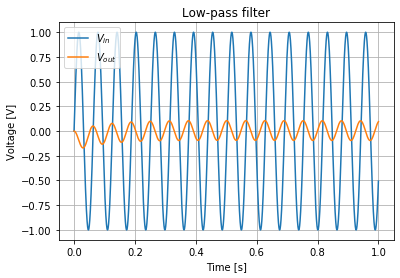

In [9]:
plt.figure()
plt.plot(t, V_in(t))
plt.plot(t, V_out)
plt.xlabel("Time [s]")
plt.ylabel("Voltage [V]")
plt.legend([r"$V_{in}$", r"$V_{out}$"], loc="upper left")
plt.title("Low-pass filter")
plt.grid()
plt.show()

Plot of the error in comparaison with the ODE solution:

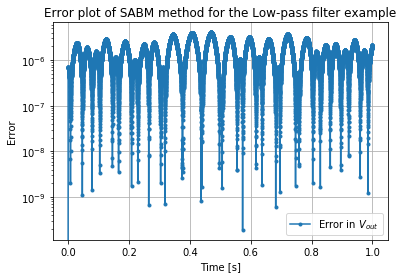

In [10]:
plt.figure()
plt.semilogy(t, abs(V_out - Vout_ODE), ".-", label='Error in $V_{out}$')
plt.title(
    f'Error plot of {kwargs["method"].__name__} method for the Low-pass filter example')
plt.xlabel('Time [s]')
plt.ylabel('Error')
plt.grid()
plt.legend()
#plt.savefig("filter_"+kwargs["method"].__name__+".png",dpi=250, bbox_inches="tight")
plt.show()